## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import torch
import cv2

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

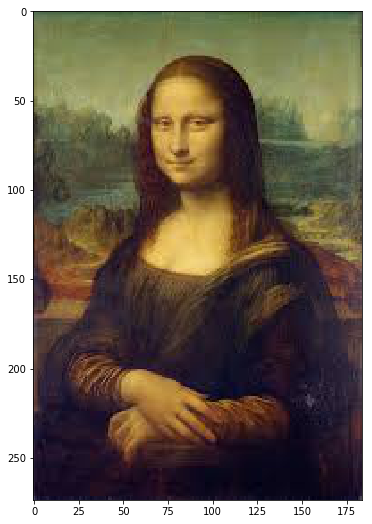

In [2]:
# load in color image for face detection
#image = cv2.imread('images/obamas.jpg')
image = cv2.imread('images/mona_lisa.jpg')
#image = cv2.imread('images/the_beatles.jpg')

# Convert from OpenCV default BGR to RGB encoding
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


Haar cascade classifier detected 1 faces.


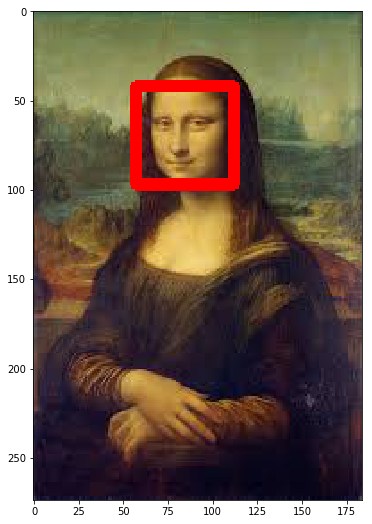

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.3, 5)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

print("Haar cascade classifier detected {} faces.".format(len(faces)))

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0), 5) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [4]:
# Set to first GPU on my own rig, to help speed up training. Using a Titan XP which saves a lot of time.
# The device identifier will be used to move tensors and network models to the GPU after creation.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from models import Net

# Create CNN and move to GPU if available
net = Net()
net.to(device)

# Load the saved weights to initialize our CNN.
# This was our best model, using batch size of 10, trained for 200 epochs
net.load_state_dict(torch.load('saved_models/keypoints_model_200epochs_rndcrop_224x224.pt'))

## Set for evalution mode
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4)
  (dense1): Linear(in_features=43264, out_features=7000, bias=True)
  (drop5): Dropout(p=0.5)
  (dense2): Linear(in_features=7000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6)
  (output): Linear(in_features=1000, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### Transform each detected face into an input Tensor

Perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




Detected 1 faces.


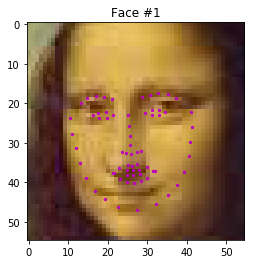

Facial keypoints on the original image.


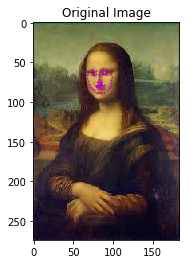

In [6]:
# Make a copy of the original image
image_copy = np.copy(image)

# Use to store the facial keypoints coordinates in the original image
orig_keypts = []

print("Detected {} faces.".format(len(faces)))

# loop over the detected faces from your haar cascade
for i, (x,y,w,h) in enumerate(faces):
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w]

    # Save the original shape of the cropped ROI with detected face. We will need this
    # later to compute the coordinates of the detected facial keypoints on the original image.
    orig_shape_crop = roi.shape
    
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    roi = roi / 255
    roi = cv2.resize(roi, (224, 224))
    
    # Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    if len(roi.shape) == 2:
        roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
    roi = roi.transpose((2, 0, 1)) # swap color axis because numpy image: H x W x C, and torch image: C X H X W
    
    # Convert numpy image into a torch tensor, reshape, and move to GPU
    roi = torch.from_numpy(roi)
    roi = roi.type(torch.cuda.FloatTensor)
    input_roi = roi.view(-1, roi.size()[0], roi.size()[1], roi.size()[2])
    input_roi = input_roi.to(device)
    
    # Make facial keypoint predictions using loaded trained network 
    # to perform a forward pass to get the predicted facial keypoints
    predicted_keypts = net(input_roi)
        
    # reshape to batch_size x 68 x 2 pts and convert to numpy array from tensor
    predicted_keypts = predicted_keypts.view(predicted_keypts.size()[0], 68, -1)
    predicted_keypts = np.squeeze(predicted_keypts.data.cpu().numpy())   

    # Un-normalize and adjust for facial keypoints on the original full image and store for later usage
    orig_x_keypts = ((predicted_keypts[:,0] * 50 + 100.) * orig_shape_crop[1]/224.) + x 
    orig_y_keypts = ((predicted_keypts[:,1] * 50 + 100.) * orig_shape_crop[0]/224.) + y 
    orig_keypts.append((orig_x_keypts, orig_y_keypts))
    
    # Un-normalize and adjust for facial keypoints on the ROI image
    roi_x_keypts = ((predicted_keypts[:,0] * 50 + 100.) * orig_shape_crop[1]/224.) 
    roi_y_keypts = ((predicted_keypts[:,1] * 50 + 100.) * orig_shape_crop[0]/224.) 
    
    # Plot the ROI color image and detected facial keypoints
    plt.imshow(image_copy[y:y+h, x:x+w])
    plt.scatter(roi_x_keypts, roi_y_keypts, marker='.', c='m', s=20)
    plt.title('Face #{}'.format(i+1))
    plt.show()
    

# Plot the original color image and plot saved facial keypoints
print("Facial keypoints on the original image.")
plt.imshow(image_copy)
plt.title('Original Image')
for x_keypts, y_keypts in orig_keypts:
    plt.scatter(x_keypts, y_keypts, marker='.', c='m', s=3)
plt.show()
